In [1]:
import os,cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
path = 'data/'
data = []
labels = []
for folders in tqdm(os.listdir(path)):
    print(folders)
    folder = path + folders
    for images_path in os.listdir(folder):
        img_path = folder + '/' + images_path
        image = cv2.imread(img_path)
        image = cv2.resize(image, (512,512))
        data.append(image)
        if folders == 'normal':
            labels.append(0)
        else:
            labels.append(1)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

defect


 50%|██████████████████████████████████████████                                          | 1/2 [00:01<00:01,  1.48s/it]

normal


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


In [3]:
data = np.array(data)#, dtype='float32')/255.0
labels = np.array(labels)

from tensorflow.keras.utils import to_categorical

labels = to_categorical(labels, 2)

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf

In [5]:
def build_model():
    inputs = layers.Input(shape=(512, 512, 3))
    model = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="ResNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [6]:
model = build_model()
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3  0           []                               
                                )]                                                                
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           ['input_1[0][0]']                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
_____________________________________________________________________________________________

In [7]:
epochs = 1 
hist = model.fit(data,labels, epochs=epochs, validation_split=0.15, verbose=1)

11/11 [==============================] - 13s 674ms/step - loss: 0.1351 - accuracy: 0.9315 - val_loss: 3.3170e-05 - val_accuracy: 1.0000


In [8]:
y_pred = model.predict(data)
y_test = labels

In [9]:
y_preds = []

for pred in y_pred:
    if pred[0] > 0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)

In [10]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_preds)
print(cf_matrix)

[[200   0]
 [  0 196]]


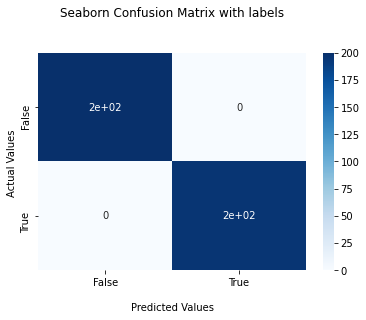

In [11]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [12]:
model.save("classifier.h5")

C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py:1382: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


[0.9996113]
Label is Defect


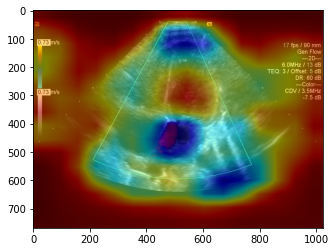

In [13]:
IMAGE_PATH = 'data/defect/0.jpg'
layer_name = 'conv5_block3_out'


img = cv2.imread(IMAGE_PATH)
img1 = cv2.resize(img, (512, 512))
imagex = np.array(img1)#, dtype="float32") / 255.0
img2 = np.expand_dims(img1,axis=0)
img2 = np.array(img2)#, dtype="float32") / 255.0

i = model.predict(img2)[0]
print(i)
if i < 0.4:
    label = 'Normal'
else:
    label = 'Defect'
print(f"Label is {label}")
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([imagex]))
    loss = predictions[:,0]
    
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]  * 1e+08
gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
denom = (cam.max() - cam.min())
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / denom
cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.5, 0)
plt.imshow(output_image)
plt.show()